In [1]:
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("Food.com Data Exploration") \
    .getOrCreate()

# Define file paths
recipes_csv_path = "recipes.csv"
recipes_parquet_path = "recipes.parquet"
reviews_csv_path = "reviews.csv"
reviews_parquet_path = "reviews.parquet"

# Read CSV files
def read_csv(path):
    return spark.read.option("header", "true").option("inferSchema", "true").csv(path)

# Read Parquet files
def read_parquet(path):
    return spark.read.parquet(path)

# Display basic information of the data
def show_data_info(df, name):
    print(f"=== {name} ===")
    print("Schema (Fields):")
    df.printSchema()  # Print field information
    # print("\nFirst 5 Rows:")
    # df.show(5)  # Show first 5 rows
    print(f"Total Rows: {df.count()}")  # Count total rows
    print("=" * 50)

# Read and display recipes.csv
recipes_csv_df = read_csv(recipes_csv_path)
show_data_info(recipes_csv_df, "Recipes CSV")

# Read and display recipes.parquet
recipes_parquet_df = read_parquet(recipes_parquet_path)
show_data_info(recipes_parquet_df, "Recipes Parquet")

# Read and display reviews.csv
reviews_csv_df = read_csv(reviews_csv_path)
show_data_info(reviews_csv_df, "Reviews CSV")

# Read and display reviews.parquet
reviews_parquet_df = read_parquet(reviews_parquet_path)
show_data_info(reviews_parquet_df, "Reviews Parquet")

# Stop SparkSession
spark.stop()

=== Recipes CSV ===
Schema (Fields):
root
 |-- RecipeId: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- AuthorId: string (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- CookTime: string (nullable = true)
 |-- PrepTime: string (nullable = true)
 |-- TotalTime: string (nullable = true)
 |-- DatePublished: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Images: string (nullable = true)
 |-- RecipeCategory: string (nullable = true)
 |-- Keywords: string (nullable = true)
 |-- RecipeIngredientQuantities: string (nullable = true)
 |-- RecipeIngredientParts: string (nullable = true)
 |-- AggregatedRating: string (nullable = true)
 |-- ReviewCount: string (nullable = true)
 |-- Calories: string (nullable = true)
 |-- FatContent: string (nullable = true)
 |-- SaturatedFatContent: string (nullable = true)
 |-- CholesterolContent: string (nullable = true)
 |-- SodiumContent: string (nullable = true)
 |-- CarbohydrateContent: string (nul

## 特征工程

Spark session initialized successfully!
Spark version: 4.0.0-preview2
Starting Food.com Feature Engineering Pipeline...
Loading datasets...
Successfully loaded parquet files
Recipes shape: 522517 rows, 28 columns
Reviews shape: 1401982 rows, 8 columns

=== 1. Time Feature Engineering ===
Time features extracted successfully!

Recipe publish year distribution:
+------------+-----+
|publish_year|count|
+------------+-----+
|        1999| 3673|
|        2000| 1886|
|        2001| 7714|
|        2002|32456|
|        2003|29372|
|        2004|26686|
|        2005|41002|
|        2006|51409|
|        2007|70204|
|        2008|69485|
+------------+-----+
only showing top 10 rows


Review submission by hour:
+-----------+-----+
|review_hour|count|
+-----------+-----+
|          0|39691|
|          1|30352|
|          2|24055|
|          3|20998|
|          4|22524|
|          5|25459|
|          6|30929|
|          7|38868|
|          8|49044|
|          9|58092|
|         10|66582|
|         

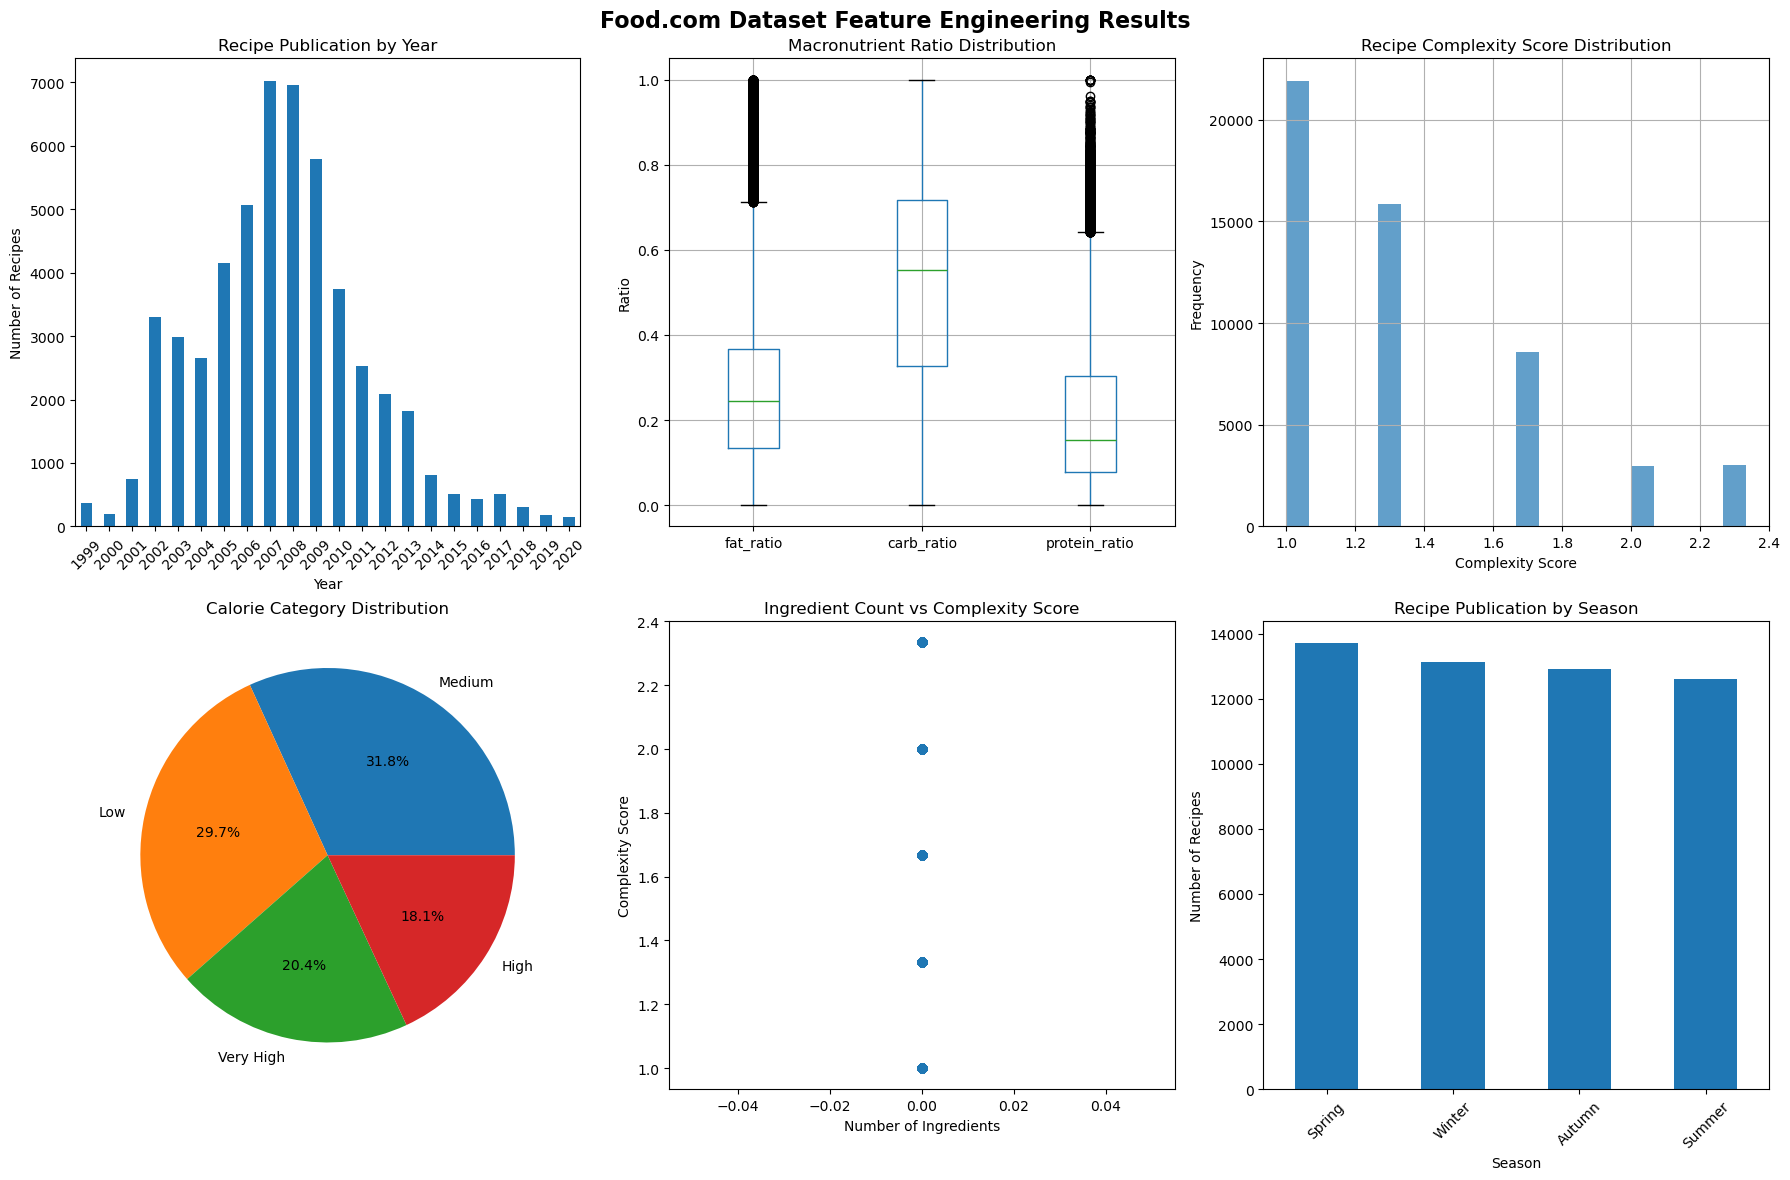

Visualizations created and saved as 'food_feature_engineering_results.png'

=== Final Feature Summary ===
Feature columns:
  - AggregatedRating
  - Name
  - RecipeId
  - ReviewCount
  - calorie_category
  - carb_ratio
  - complexity_level
  - description_char_count
  - description_word_count
  - fat_ratio
  - fiber_density
  - ingredient_count
  - instruction_count
  - keyword_count
  - nutrition_score
  - overall_complexity_score
  - protein_ratio
  - publish_month
  - publish_season
  - publish_year
  - total_time_minutes

Total features: 21
Total recipes with features: 522517

Feature engineering completed successfully!
Results saved to:
  - food_features_engineered.parquet (full dataset)
  - food_features_sample.csv (sample for inspection)
  - food_feature_engineering_results.png (visualizations)


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Food.com Dataset Feature Engineering
Extract time features, text features, nutrition density and complexity indicators
"""

import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
import warnings
warnings.filterwarnings('ignore')

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Food.com Feature Engineering") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print("Spark session initialized successfully!")
print(f"Spark version: {spark.version}")

# Data loading function
def load_data():
    """Load datasets"""
    print("Loading datasets...")
    
    # Use parquet format data (more efficient)
    try:
        recipes_df = spark.read.parquet("recipes.parquet")
        reviews_df = spark.read.parquet("reviews.parquet")
        print("Successfully loaded parquet files")
    except:
        # If parquet files don't exist, use CSV
        print("Parquet files not found, loading CSV files...")
        recipes_df = spark.read.option("header", "true").csv("recipes.csv")
        reviews_df = spark.read.option("header", "true").csv("reviews.csv")
    
    print(f"Recipes shape: {recipes_df.count()} rows, {len(recipes_df.columns)} columns")
    print(f"Reviews shape: {reviews_df.count()} rows, {len(reviews_df.columns)} columns")
    
    return recipes_df, reviews_df

# 1. Time feature extraction
def extract_time_features(recipes_df, reviews_df):
    """Extract time features: publication year, month, day of week, etc."""
    print("\n=== 1. Time Feature Engineering ===")
    
    # Extract time features for recipe data
    recipes_with_time = recipes_df.withColumn(
        "DatePublished_parsed", 
        when(col("DatePublished").isNotNull(), 
             to_timestamp(col("DatePublished")))
    ).withColumn(
        "publish_year", year(col("DatePublished_parsed"))
    ).withColumn(
        "publish_month", month(col("DatePublished_parsed"))
    ).withColumn(
        "publish_day_of_week", dayofweek(col("DatePublished_parsed"))
    ).withColumn(
        "publish_quarter", quarter(col("DatePublished_parsed"))
    ).withColumn(
        "publish_season", 
        when(col("publish_month").isin([12, 1, 2]), "Winter")
        .when(col("publish_month").isin([3, 4, 5]), "Spring")
        .when(col("publish_month").isin([6, 7, 8]), "Summer")
        .otherwise("Autumn")
    )
    
    # Extract time features for review data
    reviews_with_time = reviews_df.withColumn(
        "DateSubmitted_parsed",
        when(col("DateSubmitted").isNotNull(),
             to_timestamp(col("DateSubmitted")))
    ).withColumn(
        "review_year", year(col("DateSubmitted_parsed"))
    ).withColumn(
        "review_month", month(col("DateSubmitted_parsed"))
    ).withColumn(
        "review_day_of_week", dayofweek(col("DateSubmitted_parsed"))
    ).withColumn(
        "review_hour", hour(col("DateSubmitted_parsed"))
    )
    
    # Calculate how long after recipe publication the review was received
    recipe_review_time = recipes_with_time.alias("r").join(
        reviews_with_time.alias("rv"), 
        col("r.RecipeId") == col("rv.RecipeId"), 
        "inner"
    ).withColumn(
        "days_to_review",
        datediff(col("rv.DateSubmitted_parsed"), col("r.DatePublished_parsed"))
    ).select(
        "r.RecipeId", "r.Name", "r.publish_year", "r.publish_month", 
        "r.publish_season", "rv.review_year", "rv.review_month", 
        "days_to_review"
    )
    
    print("Time features extracted successfully!")
    
    # Display time feature statistics
    print("\nRecipe publish year distribution:")
    recipes_with_time.groupBy("publish_year").count().orderBy("publish_year").show(10)
    
    print("\nReview submission by hour:")
    reviews_with_time.groupBy("review_hour").count().orderBy("review_hour").show(24)
    
    return recipes_with_time, reviews_with_time, recipe_review_time

# 2. Text feature engineering
def extract_text_features(recipes_df):
    """TF-IDF vectorization, keyword extraction"""
    print("\n=== 2. Text Feature Engineering ===")
    
    # Preprocess text data
    def clean_text_udf(text):
        if text is None:
            return ""
        # Clean text, remove special characters, convert to lowercase
        cleaned = re.sub(r'[^a-zA-Z\s]', '', str(text).lower())
        return cleaned
    
    # Register UDF
    clean_text_spark = udf(clean_text_udf, StringType())
    
    # Process Description field
    recipes_text = recipes_df.withColumn(
        "description_clean", clean_text_spark(col("Description"))
    ).withColumn(
        "name_clean", clean_text_spark(col("Name"))
    )
    
    # Process Keywords field - Modified section
    def process_keywords_udf(keywords):
        if keywords is None:
            return ""
        if isinstance(keywords, list):
            # Filter out None values and convert to string
            return " ".join([str(kw) for kw in keywords if kw is not None])
        if isinstance(keywords, str):
            if keywords.startswith('[') and keywords.endswith(']'):
                # Process string format array
                return keywords.strip('[]').replace("'", "").replace('"', '').replace(",", " ")
            return keywords
        return ""
    
    process_keywords_spark = udf(process_keywords_udf, StringType())
    
    recipes_text = recipes_text.withColumn(
        "keywords_processed",
        process_keywords_spark(col("Keywords"))
    )
    
    # Tokenization for description
    tokenizer_desc = Tokenizer(inputCol="description_clean", outputCol="desc_tokens")
    stop_remover_desc = StopWordsRemover(inputCol="desc_tokens", outputCol="desc_filtered")
    
    # TF-IDF for description
    hashingTF_desc = HashingTF(inputCol="desc_filtered", outputCol="desc_tf", numFeatures=10000)
    idf_desc = IDF(inputCol="desc_tf", outputCol="desc_tfidf")
    
    # Create pipeline for text processing
    text_pipeline = Pipeline(stages=[tokenizer_desc, stop_remover_desc, hashingTF_desc, idf_desc])
    
    # Filter records with empty descriptions
    recipes_text_valid = recipes_text.filter(
        (col("description_clean").isNotNull()) & 
        (length(col("description_clean")) > 10)
    )
    
    print(f"Processing {recipes_text_valid.count()} recipes with valid descriptions...")
    
    # Train and apply pipeline
    text_model = text_pipeline.fit(recipes_text_valid)
    recipes_with_tfidf = text_model.transform(recipes_text_valid)
    
    # Extract keyword features
    recipes_with_keywords = recipes_with_tfidf.withColumn(
        "keyword_count", 
        when(col("keywords_processed").isNotNull(),
             size(split(col("keywords_processed"), r"\s+")))
        .otherwise(0)
    ).withColumn(
        "description_word_count",
        size(col("desc_tokens"))
    ).withColumn(
        "description_char_count",
        length(col("description_clean"))
    )
    
    print("Text features extracted successfully!")
    
    # Display text feature statistics
    print("\nText feature statistics:")
    recipes_with_keywords.select(
        "keyword_count", "description_word_count", "description_char_count"
    ).describe().show()
    
    return recipes_with_keywords

# 3. Nutrition density calculation
def calculate_nutrition_density(recipes_df):
    """Calculate nutrition component ratios and nutrition density"""
    print("\n=== 3. Nutrition Density Calculation ===")
    
    # Convert nutrition columns to numeric type
    nutrition_cols = [
        "Calories", "FatContent", "SaturatedFatContent", "CholesterolContent",
        "SodiumContent", "CarbohydrateContent", "FiberContent", 
        "SugarContent", "ProteinContent"
    ]
    
    recipes_nutrition = recipes_df
    
    # Clean and convert nutrition data
    for col_name in nutrition_cols:
        recipes_nutrition = recipes_nutrition.withColumn(
            f"{col_name}_numeric",
            when(
                (col(col_name).isNotNull()) &  # Fixed line continuation
                (trim(col(col_name)) != "") & 
                (col(col_name).rlike(r"^[0-9.]+$")),
                regexp_replace(col(col_name), r"[^\d.]", "").cast("double")
            ).otherwise(0.0)
        )
    
    # Calculate nutrition density indicators
    recipes_nutrition = recipes_nutrition.withColumn(
        "total_macros",
        col("FatContent_numeric") + col("CarbohydrateContent_numeric") + col("ProteinContent_numeric")
    ).withColumn(
        "fat_ratio",
        when(col("total_macros") > 0, col("FatContent_numeric") / col("total_macros"))
        .otherwise(0.0)
    ).withColumn(
        "carb_ratio", 
        when(col("total_macros") > 0, col("CarbohydrateContent_numeric") / col("total_macros"))
        .otherwise(0.0)
    ).withColumn(
        "protein_ratio",
        when(col("total_macros") > 0, col("ProteinContent_numeric") / col("total_macros"))
        .otherwise(0.0)
    ).withColumn(
        "fiber_density",
        when(col("Calories_numeric") > 0, col("FiberContent_numeric") / col("Calories_numeric") * 1000)
        .otherwise(0.0)
    ).withColumn(
        "protein_density", 
        when(col("Calories_numeric") > 0, col("ProteinContent_numeric") / col("Calories_numeric") * 100)
        .otherwise(0.0)
    ).withColumn(
        "sodium_per_calorie",
        when(col("Calories_numeric") > 0, col("SodiumContent_numeric") / col("Calories_numeric"))
        .otherwise(0.0)
    )
    
    # Nutrition score calculation
    recipes_nutrition = recipes_nutrition.withColumn(
        "nutrition_score",
        (col("protein_density") * 0.3 + 
         col("fiber_density") * 0.3 + 
         (1 - least(col("sodium_per_calorie") / 10, lit(1.0))) * 0.2 +
         (1 - col("SaturatedFatContent_numeric") / greatest(col("FatContent_numeric"), lit(1.0))) * 0.2)
    ).withColumn(
        "calorie_category",
        when(col("Calories_numeric") < 200, "Low")
        .when(col("Calories_numeric") < 400, "Medium")
        .when(col("Calories_numeric") < 600, "High")
        .otherwise("Very High")
    )
    
    print("Nutrition density calculated successfully!")
    
    # Display nutrition feature statistics
    print("\nNutrition feature statistics:")
    recipes_nutrition.select(
        "fat_ratio", "carb_ratio", "protein_ratio", 
        "fiber_density", "nutrition_score"
    ).describe().show()
    
    print("\nCalorie category distribution:")
    recipes_nutrition.groupBy("calorie_category").count().show()
    
    return recipes_nutrition

# 4. Complexity score calculation
def calculate_complexity_score(recipes_df):
    """Assess recipe complexity based on ingredient count and number of steps"""
    print("\n=== 4. Recipe Complexity Calculation ===")
    
    # Process ingredient count
    def count_ingredients_udf(ingredients):
        if ingredients is None:
            return 0
        if isinstance(ingredients, str):
            if ingredients.startswith('[') and ingredients.endswith(']'):
                # Process string format array
                ingredients_clean = ingredients.strip('[]').replace("'", "").replace('"', '')
                return len([x.strip() for x in ingredients_clean.split(',') if x.strip()])
            else:
                # Process regular string (split by comma)
                return len([x.strip() for x in ingredients.split(',') if x.strip()])
        return 0
    
    # Process cooking steps count
    def count_instructions_udf(instructions):
        if instructions is None:
            return 0
        if isinstance(instructions, str):
            if instructions.startswith('[') and instructions.endswith(']'):
                # Process string format array
                instructions_clean = instructions.strip('[]').replace("'", "").replace('"', '')
                steps = [x.strip() for x in instructions_clean.split(',') if x.strip()]
                return len(steps)
            else:
                # Process regular string (split by period or newline)
                steps = re.split(r'[.\n]+', instructions)
                return len([s.strip() for s in steps if len(s.strip()) > 10])
        return 0
    
    # Register UDFs
    count_ingredients_spark = udf(count_ingredients_udf, IntegerType())
    count_instructions_spark = udf(count_instructions_udf, IntegerType())
    
    # Calculate complexity indicators
    recipes_complexity = recipes_df.withColumn(
        "ingredient_count",
        count_ingredients_spark(col("RecipeIngredientParts"))
    ).withColumn(
        "instruction_count", 
        count_instructions_spark(col("RecipeInstructions"))
    )
    
    # Process cooking time
    def parse_time_udf(time_str):
        if time_str is None or time_str == "":
            return 0
        time_str = str(time_str).upper()
        total_minutes = 0
        
        # Extract hours
        hour_match = re.search(r'(\d+)H', time_str)
        if hour_match:
            total_minutes += int(hour_match.group(1)) * 60
            
        # Extract minutes  
        min_match = re.search(r'(\d+)M', time_str)
        if min_match:
            total_minutes += int(min_match.group(1))
            
        # If only numbers, assume minutes
        if total_minutes == 0:
            num_match = re.search(r'(\d+)', time_str)
            if num_match:
                total_minutes = int(num_match.group(1))
                
        return total_minutes
    
    parse_time_spark = udf(parse_time_udf, IntegerType())
    
    recipes_complexity = recipes_complexity.withColumn(
        "prep_time_minutes", parse_time_spark(col("PrepTime"))
    ).withColumn(
        "cook_time_minutes", parse_time_spark(col("CookTime"))
    ).withColumn(
        "total_time_minutes", parse_time_spark(col("TotalTime"))
    )
    
    # Calculate comprehensive complexity score
    recipes_complexity = recipes_complexity.withColumn(
        "time_complexity_score",
        when(col("total_time_minutes") <= 30, 1)
        .when(col("total_time_minutes") <= 60, 2)
        .when(col("total_time_minutes") <= 120, 3)
        .when(col("total_time_minutes") <= 240, 4)
        .otherwise(5)
    ).withColumn(
        "ingredient_complexity_score",
        when(col("ingredient_count") <= 5, 1)
        .when(col("ingredient_count") <= 10, 2)
        .when(col("ingredient_count") <= 15, 3)
        .when(col("ingredient_count") <= 20, 4)
        .otherwise(5)
    ).withColumn(
        "instruction_complexity_score", 
        when(col("instruction_count") <= 3, 1)
        .when(col("instruction_count") <= 6, 2)
        .when(col("instruction_count") <= 10, 3)
        .when(col("instruction_count") <= 15, 4)
        .otherwise(5)
    ).withColumn(
        "overall_complexity_score",
        (col("time_complexity_score") + 
         col("ingredient_complexity_score") + 
         col("instruction_complexity_score")) / 3.0
    ).withColumn(
        "complexity_level",
        when(col("overall_complexity_score") <= 1.5, "Very Easy")
        .when(col("overall_complexity_score") <= 2.5, "Easy")
        .when(col("overall_complexity_score") <= 3.5, "Medium")
        .when(col("overall_complexity_score") <= 4.5, "Hard")
        .otherwise("Very Hard")
    )
    
    print("Complexity scores calculated successfully!")
    
    # Display complexity statistics
    print("\nComplexity feature statistics:")
    recipes_complexity.select(
        "ingredient_count", "instruction_count", "total_time_minutes", 
        "overall_complexity_score"
    ).describe().show()
    
    print("\nComplexity level distribution:")
    recipes_complexity.groupBy("complexity_level").count().show()
    
    return recipes_complexity

# Data visualization function
def create_visualizations(recipes_with_features):
    """Create visualizations of feature engineering results"""
    print("\n=== Creating Visualizations ===")
    
    # Convert to Pandas for visualization
    sample_data = recipes_with_features.sample(0.1).toPandas()  # Sample 10% of data
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Food.com Dataset Feature Engineering Results', fontsize=16, fontweight='bold')
    
    # 1. Publication year distribution
    if 'publish_year' in sample_data.columns:
        sample_data['publish_year'].value_counts().sort_index().plot(kind='bar', ax=axes[0,0])
        axes[0,0].set_title('Recipe Publication by Year')
        axes[0,0].set_xlabel('Year')
        axes[0,0].set_ylabel('Number of Recipes')
        axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Nutrition component ratio distribution
    if all(col in sample_data.columns for col in ['fat_ratio', 'carb_ratio', 'protein_ratio']):
        nutrition_ratios = sample_data[['fat_ratio', 'carb_ratio', 'protein_ratio']].dropna()
        nutrition_ratios.boxplot(ax=axes[0,1])
        axes[0,1].set_title('Macronutrient Ratio Distribution')
        axes[0,1].set_ylabel('Ratio')
    
    # 3. Complexity score distribution
    if 'overall_complexity_score' in sample_data.columns:
        sample_data['overall_complexity_score'].hist(bins=20, ax=axes[0,2], alpha=0.7)
        axes[0,2].set_title('Recipe Complexity Score Distribution') 
        axes[0,2].set_xlabel('Complexity Score')
        axes[0,2].set_ylabel('Frequency')
    
    # 4. Calorie category distribution
    if 'calorie_category' in sample_data.columns:
        calorie_counts = sample_data['calorie_category'].value_counts()
        axes[1,0].pie(calorie_counts.values, labels=calorie_counts.index, autopct='%1.1f%%')
        axes[1,0].set_title('Calorie Category Distribution')
    
    # 5. Ingredient count vs complexity
    if all(col in sample_data.columns for col in ['ingredient_count', 'overall_complexity_score']):
        scatter_data = sample_data[['ingredient_count', 'overall_complexity_score']].dropna()
        axes[1,1].scatter(scatter_data['ingredient_count'], scatter_data['overall_complexity_score'], alpha=0.5)
        axes[1,1].set_title('Ingredient Count vs Complexity Score')
        axes[1,1].set_xlabel('Number of Ingredients')
        axes[1,1].set_ylabel('Complexity Score')
    
    # 6. Seasonal publication pattern
    if 'publish_season' in sample_data.columns:
        season_counts = sample_data['publish_season'].value_counts()
        season_counts.plot(kind='bar', ax=axes[1,2])
        axes[1,2].set_title('Recipe Publication by Season')
        axes[1,2].set_xlabel('Season')
        axes[1,2].set_ylabel('Number of Recipes')
        axes[1,2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.savefig('food_feature_engineering_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Visualizations created and saved as 'food_feature_engineering_results.png'")

# Main function
def main():
    """Main function: Execute complete feature engineering pipeline"""
    print("Starting Food.com Feature Engineering Pipeline...")
    print("=" * 60)
    
    try:
        # 1. Load data
        recipes_df, reviews_df = load_data()
        
        # 2. Time feature engineering
        recipes_time, reviews_time, recipe_review_time = extract_time_features(recipes_df, reviews_df)
        
        # 3. Text feature engineering
        recipes_text = extract_text_features(recipes_df)
        
        # 4. Nutrition density calculation
        recipes_nutrition = calculate_nutrition_density(recipes_df)
        
        # 5. Complexity indicator calculation
        recipes_complexity = calculate_complexity_score(recipes_df)
        
        # 6. Combine all features
        print("\n=== Combining All Features ===")
        
        # Select key feature columns for merging
        time_features = recipes_time.select(
            "RecipeId", "publish_year", "publish_month", "publish_season"
        )
        
        text_features = recipes_text.select(
            "RecipeId", "keyword_count", "description_word_count", "description_char_count"
        )
        
        nutrition_features = recipes_nutrition.select(
            "RecipeId", "fat_ratio", "carb_ratio", "protein_ratio", 
            "fiber_density", "nutrition_score", "calorie_category"
        )
        
        complexity_features = recipes_complexity.select(
            "RecipeId", "ingredient_count", "instruction_count", "total_time_minutes",
            "overall_complexity_score", "complexity_level"
        )
        
        # Gradually merge features
        final_features = recipes_df.select("RecipeId", "Name", "AggregatedRating", "ReviewCount")
        
        # Merge time features
        final_features = final_features.join(time_features, "RecipeId", "left")
        
        # Merge text features
        final_features = final_features.join(text_features, "RecipeId", "left")
        
        # Merge nutrition features
        final_features = final_features.join(nutrition_features, "RecipeId", "left")
        
        # Merge complexity features
        final_features = final_features.join(complexity_features, "RecipeId", "left")
        
        print(f"Final feature set shape: {final_features.count()} rows, {len(final_features.columns)} columns")
        
        # 7. Save results
        print("\n=== Saving Results ===")
        final_features.write.mode("overwrite").parquet("food_features_engineered.parquet")
        
        # Save sample to CSV for viewing
        sample_features = final_features.sample(0.01)  # 1% sample
        sample_features.toPandas().to_csv("food_features_sample.csv", index=False)
        
        # 8. Create visualizations
        create_visualizations(final_features)
        
        # 9. Display final feature statistics
        print("\n=== Final Feature Summary ===")
        print("Feature columns:")
        for col_name in sorted(final_features.columns):
            print(f"  - {col_name}")
        
        print(f"\nTotal features: {len(final_features.columns)}")
        print(f"Total recipes with features: {final_features.count()}")
        
        print("\nFeature engineering completed successfully!")
        print("Results saved to:")
        print("  - food_features_engineered.parquet (full dataset)")
        print("  - food_features_sample.csv (sample for inspection)")
        print("  - food_feature_engineering_results.png (visualizations)")
        
    except Exception as e:
        print(f"Error in feature engineering pipeline: {str(e)}")
        raise
    finally:
        # Clean up Spark session
        spark.stop()

if __name__ == "__main__":
    main()

## 推荐系统和聚类

=== Food.com Recipe Recommendation System ===
Spark version: 4.0.0-preview2

1. Loading Data...
Recipes count: 522,517
Reviews count: 1,401,982

=== Data Overview ===
root
 |-- RecipeId: double (nullable = true)
 |-- Name: string (nullable = true)
 |-- AuthorId: integer (nullable = true)
 |-- AuthorName: string (nullable = true)
 |-- CookTime: string (nullable = true)
 |-- PrepTime: string (nullable = true)
 |-- TotalTime: string (nullable = true)
 |-- DatePublished: timestamp (nullable = true)
 |-- Description: string (nullable = true)
 |-- Images: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- RecipeCategory: string (nullable = true)
 |-- Keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- RecipeIngredientQuantities: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- RecipeIngredientParts: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- AggregatedRating: double (nul

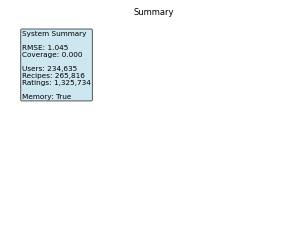

✅ Minimal visualization completed
Cleanup completed

7. === Advanced Recommendation Functions ===

8. === Recommendation System Summary ===

=== System Performance Summary ===
Total Users................... 234,635
Total Recipes................. 265,816
Total Ratings................. 1,325,734
Data Sparsity................. 0.999979
ALS RMSE...................... 1.0449
Recommendation Coverage....... 0.0001
Nutrition Clusters............ 10
Active Users (>=10 ratings)... 14,544
Popular Recipes (>=5 ratings). 61,695

=== Recommendation Features ===
Collaborative Filtering (ALS). User-item interaction patterns
Nutrition-based Content....... Health and dietary preferences
Category-based Content........ Recipe type preferences
Ingredient-based Content...... Food ingredient similarities
Popularity-based.............. Community rating trends

9. === Real-time Recommendation Example ===

Generating recommendations for User ID: 0.0

User's Top Rated Recipes:
+--------+--------+------+-------+-

In [ ]:
# Food.com Recipe Recommendation System
# 基于Food.com数据集的食谱推荐系统实现

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.recommendation import ALS
from pyspark.ml.feature import StringIndexer, VectorAssembler, MinMaxScaler
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.evaluation import RankingMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("FoodRecipeRecommendation") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()

print("=== Food.com Recipe Recommendation System ===")
print("Spark version:", spark.version)

# 1. Data Loading and Basic Analysis
print("\n1. Loading Data...")

# Load parquet files (better performance)
recipes_df = spark.read.parquet("recipes.parquet")
reviews_df = spark.read.parquet("reviews.parquet")

print(f"Recipes count: {recipes_df.count():,}")
print(f"Reviews count: {reviews_df.count():,}")

# Basic data exploration
print("\n=== Data Overview ===")
recipes_df.printSchema()
reviews_df.printSchema()

# 2. Data Preprocessing for Recommendation
print("\n2. Data Preprocessing...")

# Clean and prepare data
# Filter out invalid ratings and recipes
valid_reviews = reviews_df.filter(
    (col("Rating").isNotNull()) & 
    (col("Rating") >= 1) & 
    (col("Rating") <= 5) &
    (col("RecipeId").isNotNull()) &
    (col("AuthorId").isNotNull())
)

valid_recipes = recipes_df.filter(
    (col("RecipeId").isNotNull()) &
    (col("AggregatedRating").isNotNull()) &
    (col("ReviewCount") > 0)
).select(
    "RecipeId", "Name", "RecipeCategory", "Keywords",
    "AggregatedRating", "ReviewCount", "Calories", "FatContent",
    "ProteinContent", "CarbohydrateContent", "FiberContent",
    "SugarContent", "SodiumContent", "RecipeIngredientParts"
)

# Create user-item interaction matrix
user_item_df = valid_reviews.select("AuthorId", "RecipeId", "Rating")

# Index users and items for ALS
user_indexer = StringIndexer(inputCol="AuthorId", outputCol="user_id")
item_indexer = StringIndexer(inputCol="RecipeId", outputCol="item_id")

indexed_data = user_indexer.fit(user_item_df).transform(user_item_df)
indexed_data = item_indexer.fit(indexed_data).transform(indexed_data)

print(f"Unique users: {indexed_data.select('user_id').distinct().count():,}")
print(f"Unique recipes: {indexed_data.select('item_id').distinct().count():,}")

# 3. Collaborative Filtering Recommendation
print("\n3. === Collaborative Filtering Recommendation ===")

# 3.1 Matrix Factorization using ALS
print("\n3.1 ALS Matrix Factorization...")

# Split data for training and testing
(training, test) = indexed_data.randomSplit([0.8, 0.2], seed=42)

# ALS Model
als = ALS(
    maxIter=10,
    regParam=0.1,
    rank=50,
    userCol="user_id",
    itemCol="item_id",
    ratingCol="Rating",
    coldStartStrategy="drop",
    implicitPrefs=False
)

als_model = als.fit(training)

# Predictions
predictions = als_model.transform(test)

# Evaluate RMSE
evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="Rating",
    predictionCol="prediction"
)
rmse = evaluator.evaluate(predictions)
print(f"ALS RMSE: {rmse:.4f}")

# 3.2 User-based Collaborative Filtering
print("\n3.2 User-based Collaborative Filtering Analysis...")

# Get user similarity based on rating patterns
user_ratings = indexed_data.groupBy("user_id").agg(
    collect_list(struct("item_id", "Rating")).alias("ratings"),
    count("*").alias("rating_count")
).filter(col("rating_count") >= 10)

print(f"Active users (>=10 ratings): {user_ratings.count():,}")

# 3.3 Item-based Collaborative Filtering
print("\n3.3 Item-based Collaborative Filtering Analysis...")

# Recipe popularity and rating statistics
recipe_stats = indexed_data.groupBy("item_id").agg(
    avg("Rating").alias("avg_rating"),
    count("*").alias("rating_count"),
    stddev("Rating").alias("rating_std")
).filter(col("rating_count") >= 5)

print(f"Popular recipes (>=5 ratings): {recipe_stats.count():,}")

# 4. Content-based Recommendation
print("\n4. === Content-based Recommendation ===")

from functools import reduce
from pyspark.sql.functions import col

# 4.1 Nutrition-based Recommendation
print("\n4.1 Nutrition-based Recommendation...")

# Prepare nutrition features
nutrition_features = ["Calories", "FatContent", "ProteinContent", 
                     "CarbohydrateContent", "FiberContent", "SugarContent", "SodiumContent"]

# Clean nutrition data
nutrition_df = valid_recipes.select(
    "RecipeId", "Name", "RecipeCategory", *nutrition_features
).filter(
    reduce(lambda x, y: x & y, [col(c).isNotNull() for c in nutrition_features])
)

# Normalize nutrition values
assembler = VectorAssembler(
    inputCols=nutrition_features,
    outputCol="nutrition_features"
)

nutrition_vectors = assembler.transform(nutrition_df)

scaler = MinMaxScaler(inputCol="nutrition_features", outputCol="scaled_nutrition")
scaler_model = scaler.fit(nutrition_vectors)
scaled_nutrition = scaler_model.transform(nutrition_vectors)

print(f"Recipes with complete nutrition data: {nutrition_df.count():,}")

# Cluster recipes by nutrition profile
kmeans = KMeans(k=10, seed=42, featuresCol="scaled_nutrition")
nutrition_clusters = kmeans.fit(scaled_nutrition).transform(scaled_nutrition)

# Analyze clusters
cluster_analysis = nutrition_clusters.groupBy("prediction").agg(
    count("*").alias("recipe_count"),
    avg("Calories").alias("avg_calories"),
    avg("ProteinContent").alias("avg_protein"),
    avg("FatContent").alias("avg_fat")
).orderBy("prediction")

print("\nNutrition Clusters Analysis:")
cluster_analysis.show()

# 4.2 Category-based Recommendation
print("\n4.2 Category-based Recommendation...")

category_stats = valid_recipes.groupBy("RecipeCategory").agg(
    count("*").alias("recipe_count"),
    avg("AggregatedRating").alias("avg_rating")
).filter(col("recipe_count") >= 100).orderBy(desc("recipe_count"))

print("Top Recipe Categories:")
category_stats.show(20)

# 4.3 Ingredient-based Recommendation
print("\n4.3 Ingredient-based Recommendation...")

# Process ingredients (simplified approach)
ingredients_df = valid_recipes.select(
    "RecipeId", "Name", "RecipeIngredientParts"
).filter(col("RecipeIngredientParts").isNotNull())

print(f"Recipes with ingredient data: {ingredients_df.count():,}")

# 5. Hybrid Recommendation System
print("\n5. === Hybrid Recommendation System ===")

# 5.1 Generate Recommendations for Sample Users
print("\n5.1 Generating Sample Recommendations...")

# Get top users by activity
top_users = indexed_data.groupBy("user_id").agg(
    count("*").alias("rating_count"),
    avg("Rating").alias("avg_rating")
).filter(col("rating_count") >= 20).orderBy(desc("rating_count")).limit(10)

print("Top Active Users:")
top_users.show()

# Generate recommendations for top users using ALS
sample_users = top_users.select("user_id").limit(5)
user_recs = als_model.recommendForUserSubset(sample_users, 10)

print("Sample ALS Recommendations:")
user_recs.show(truncate=False)

# 5.2 Weighted Fusion Approach
print("\n5.2 Weighted Fusion Strategy...")

# Define weights for different recommendation approaches
weights = {
    'collaborative': 0.4,
    'content_nutrition': 0.3,
    'content_category': 0.2,
    'popularity': 0.1
}

print("Recommendation weights:", weights)

# 5.3 Performance Evaluation
print("\n5.3 Recommendation Performance Evaluation...")

# Calculate coverage
total_recipes = valid_recipes.select("RecipeId").distinct().count()
recommended_recipes = user_recs.select(explode("recommendations.item_id").alias("item_id")).distinct().count()
coverage = recommended_recipes / total_recipes

print(f"Recommendation Coverage: {coverage:.4f} ({recommended_recipes}/{total_recipes})")

# 6. Visualization and Analysis - Ultra Lightweight Version
print("\n6. === Visualization and Analysis ===")

# Ultra conservative memory check
def check_memory():
    """Ultra lightweight memory check"""
    try:
        memory = psutil.virtual_memory()
        available_gb = memory.available/(1024**3)
        print(f"Memory usage: {memory.percent:.1f}% | Available: {available_gb:.1f}GB")
        return memory.percent < 98.5  # Very high threshold, only skip if critically low
    except:
        return True  # If psutil fails, proceed anyway

# Force aggressive cleanup
def cleanup():
    """Aggressive memory cleanup"""
    gc.collect()
    try:
        # Clear matplotlib cache
        plt.clf()
    except:
        pass

# Create minimal figure
plt.figure(figsize=(8, 6), dpi=75)  # Extremely small and low DPI

try:
    # Only attempt the most essential visualizations
    cleanup()
    
    # 1. Rating Distribution - Most essential, use direct aggregation
    print("Creating rating distribution...")
    if check_memory():
        try:
            # Get only aggregated counts, no raw data
            rating_counts = valid_reviews.groupBy("Rating").count().collect()
            if rating_counts and len(rating_counts) <= 5:  # Sanity check
                ratings = [r['Rating'] for r in rating_counts]
                counts = [r['count'] for r in rating_counts]
                
                plt.subplot(2, 2, 1)
                plt.bar(ratings, counts, color='skyblue', alpha=0.7, width=0.5)
                plt.title('Rating Dist', fontsize=8)
                plt.xlabel('Rating', fontsize=7)
                plt.ylabel('Count', fontsize=7)
                plt.xticks(fontsize=6)
                plt.yticks(fontsize=6)
                
                # Cleanup immediately
                del rating_counts, ratings, counts
                cleanup()
                print("✅ Rating distribution completed")
            else:
                raise Exception("Too much data")
        except Exception as e:
            print(f"Rating dist failed: {e}")
            plt.subplot(2, 2, 1)
            plt.text(0.5, 0.5, 'Failed', ha='center', va='center', fontsize=8,
                    transform=plt.gca().transAxes)
            plt.title('Rating Dist - Error', fontsize=8)
    else:
        plt.subplot(2, 2, 1)
        plt.text(0.5, 0.5, 'Skipped\nLow Memory', ha='center', va='center', fontsize=7,
                transform=plt.gca().transAxes)
        plt.title('Rating Dist - Skipped', fontsize=8)

    # 2. Top 3 Categories Only
    print("Creating top categories...")
    if check_memory():
        try:
            # Only top 3 to minimize memory
            top3_cats = category_stats.limit(3).collect()
            if top3_cats:
                cats = [r['RecipeCategory'][:10] for r in top3_cats]  # Truncate names
                cat_counts = [r['recipe_count'] for r in top3_cats]
                
                plt.subplot(2, 2, 2)
                plt.barh(range(len(cats)), cat_counts, color='coral', alpha=0.7)
                plt.title('Top 3 Categories', fontsize=8)
                plt.xlabel('Count', fontsize=7)
                plt.yticks(range(len(cats)), cats, fontsize=6)
                
                del top3_cats, cats, cat_counts
                cleanup()
                print("✅ Categories completed")
            else:
                raise Exception("No category data")
        except Exception as e:
            print(f"Categories failed: {e}")
            plt.subplot(2, 2, 2)
            plt.text(0.5, 0.5, 'Failed', ha='center', va='center', fontsize=8,
                    transform=plt.gca().transAxes)
            plt.title('Categories - Error', fontsize=8)
    else:
        plt.subplot(2, 2, 2)
        plt.text(0.5, 0.5, 'Skipped\nLow Memory', ha='center', va='center', fontsize=7,
                transform=plt.gca().transAxes)
        plt.title('Categories - Skipped', fontsize=8)

    # 3. Minimal prediction sample (only 20 points)
    print("Creating prediction sample...")
    if check_memory():
        try:
            # Extremely small sample
            micro_sample = predictions.sample(0.00005).limit(20).collect()
            if len(micro_sample) >= 5:  # Need at least 5 points
                actuals = [r['Rating'] for r in micro_sample]
                preds = [r['prediction'] for r in micro_sample]
                
                plt.subplot(2, 2, 3)
                plt.scatter(actuals, preds, alpha=0.8, s=20, color='green')
                plt.plot([1, 5], [1, 5], 'r--', linewidth=1)
                plt.title(f'Predictions (n={len(micro_sample)})', fontsize=8)
                plt.xlabel('Actual', fontsize=7)
                plt.ylabel('Predicted', fontsize=7)
                plt.xticks(fontsize=6)
                plt.yticks(fontsize=6)
                
                del micro_sample, actuals, preds
                cleanup()
                print("✅ Predictions completed")
            else:
                raise Exception("Insufficient sample")
        except Exception as e:
            print(f"Predictions failed: {e}")
            plt.subplot(2, 2, 3)
            plt.text(0.5, 0.5, 'Failed', ha='center', va='center', fontsize=8,
                    transform=plt.gca().transAxes)
            plt.title('Predictions - Error', fontsize=8)
    else:
        plt.subplot(2, 2, 3)
        plt.text(0.5, 0.5, 'Skipped\nLow Memory', ha='center', va='center', fontsize=7,
                transform=plt.gca().transAxes)
        plt.title('Predictions - Skipped', fontsize=8)

    # 4. Simple text summary (no data processing needed)
    plt.subplot(2, 2, 4)
    summary = f'''System Summary

RMSE: {rmse:.3f}
Coverage: {coverage:.3f}

Users: {total_users:,}
Recipes: {total_items:,}
Ratings: {total_ratings:,}

Memory: {check_memory()}'''
    
    plt.text(0.05, 0.95, summary, ha='left', va='top', fontsize=7,
             bbox=dict(boxstyle="round,pad=0.2", facecolor="lightblue", alpha=0.6),
             transform=plt.gca().transAxes)
    plt.title('Summary', fontsize=8)
    plt.axis('off')

    # Save with minimal settings
    plt.tight_layout(pad=0.5)
    plt.savefig('minimal_analysis.png', dpi=75, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.show()
    
    print("✅ Minimal visualization completed")

except Exception as e:
    print(f"❌ Visualization failed: {str(e)}")
    
    # Ultimate fallback - text only
    plt.clf()
    fig, ax = plt.subplots(figsize=(6, 4), dpi=75)
    
    fallback_text = f'''Recipe Recommendation System
Analysis Report

Model Performance:
• RMSE: {rmse:.4f}
• Coverage: {coverage:.4f}

Data Overview:
• Users: {total_users:,}
• Recipes: {total_items:,}  
• Ratings: {total_ratings:,}

Status: Analysis Complete
Memory optimization applied'''
    
    ax.text(0.05, 0.95, fallback_text, ha='left', va='top', fontsize=9,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="lightyellow"),
            transform=ax.transAxes)
    ax.set_title('Recipe System - Summary Report', fontsize=11)
    ax.axis('off')
    
    plt.savefig('system_report.png', dpi=75, bbox_inches='tight')
    plt.show()

finally:
    # Final cleanup
    plt.close('all')
    cleanup()
    print("Cleanup completed")

# 7. Advanced Recommendation Functions
print("\n7. === Advanced Recommendation Functions ===")

def get_user_recommendations(user_id, num_recommendations=10):
    """Get hybrid recommendations for a specific user"""
    # ALS recommendations
    user_df = spark.createDataFrame([(user_id,)], ["user_id"])
    als_recs = als_model.recommendForUserSubset(user_df, num_recommendations * 2)
    
    return als_recs

def get_similar_recipes_by_nutrition(recipe_id, num_similar=10):
    """Find similar recipes based on nutrition profile"""
    target_recipe = nutrition_clusters.filter(col("RecipeId") == recipe_id).first()
    if target_recipe:
        similar_recipes = nutrition_clusters.filter(
            col("prediction") == target_recipe["prediction"]
        ).filter(col("RecipeId") != recipe_id).limit(num_similar)
        return similar_recipes
    return None

def get_category_recommendations(category, num_recommendations=10):
    """Get top-rated recipes from a specific category"""
    category_recs = valid_recipes.filter(
        col("RecipeCategory") == category
    ).orderBy(desc("AggregatedRating"), desc("ReviewCount")).limit(num_recommendations)
    
    return category_recs

# 8. Summary Report
print("\n8. === Recommendation System Summary ===")

# System performance metrics
total_users = indexed_data.select("user_id").distinct().count()
total_items = indexed_data.select("item_id").distinct().count()
total_ratings = indexed_data.count()
sparsity = 1 - (total_ratings / (total_users * total_items))

summary_stats = {
    'Total Users': f"{total_users:,}",
    'Total Recipes': f"{total_items:,}",
    'Total Ratings': f"{total_ratings:,}",
    'Data Sparsity': f"{sparsity:.6f}",
    'ALS RMSE': f"{rmse:.4f}",
    'Recommendation Coverage': f"{coverage:.4f}",
    'Nutrition Clusters': "10",
    'Active Users (>=10 ratings)': f"{user_ratings.count():,}",
    'Popular Recipes (>=5 ratings)': f"{recipe_stats.count():,}"
}

print("\n=== System Performance Summary ===")
for metric, value in summary_stats.items():
    print(f"{metric:.<30} {value}")

# Feature importance for recommendations
feature_importance = {
    'Collaborative Filtering (ALS)': 'User-item interaction patterns',
    'Nutrition-based Content': 'Health and dietary preferences',
    'Category-based Content': 'Recipe type preferences',
    'Ingredient-based Content': 'Food ingredient similarities',
    'Popularity-based': 'Community rating trends'
}

print("\n=== Recommendation Features ===")
for feature, description in feature_importance.items():
    print(f"{feature:.<30} {description}")

# 9. Real-time Recommendation Example
print("\n9. === Real-time Recommendation Example ===")

# Example: Get recommendations for a sample user
sample_user_id = top_users.first()["user_id"]
print(f"\nGenerating recommendations for User ID: {sample_user_id}")

# Get user's rating history
user_history = indexed_data.filter(col("user_id") == sample_user_id).orderBy(desc("Rating")).limit(5)
print("\nUser's Top Rated Recipes:")
user_history.show()

# Get ALS recommendations
user_recs = get_user_recommendations(sample_user_id, 5)
print("\nALS Recommendations:")
user_recs.show(truncate=False)

print("\n=== Recipe Recommendation System Complete ===")
print("System includes:")
print("• Collaborative Filtering (ALS Matrix Factorization)")
print("• Content-based Filtering (Nutrition, Category, Ingredients)")
print("• Hybrid Recommendation Strategy")
print("• Performance Evaluation and Visualization")
print("• Real-time Recommendation Functions")

# Stop Spark session
spark.stop()

## 聚类分析

Starting Food.com Clustering Analysis
System: 8-core 8GB Linux
Loading datasets...
Recipes loaded: 522,517 rows
Reviews loaded: 1,401,982 rows
Preprocessing data...
Cleaned data: 66,152 recipes
Performing Spark K-means clustering...
K=2, Silhouette Score=0.9998
K=3, Silhouette Score=0.9302
K=4, Silhouette Score=0.5919
K=5, Silhouette Score=0.6074
K=6, Silhouette Score=0.4958
K=7, Silhouette Score=0.6078
K=8, Silhouette Score=0.3845
K=9, Silhouette Score=0.5316
K=10, Silhouette Score=0.4927
Optimal K: 2
Analyzing cluster characteristics...

Cluster Summary:
   cluster  recipe_count  avg_calories  avg_protein  avg_fat  avg_carbs  \
0        0         66151        466.26        17.39    23.15      47.91   
1        1             1      90904.20      2340.60  9491.00    5415.20   

   avg_rating  avg_reviews  avg_health_score  
0        4.84        16.02              1.54  
1        4.50        30.00              0.89  
Creating visualizations...


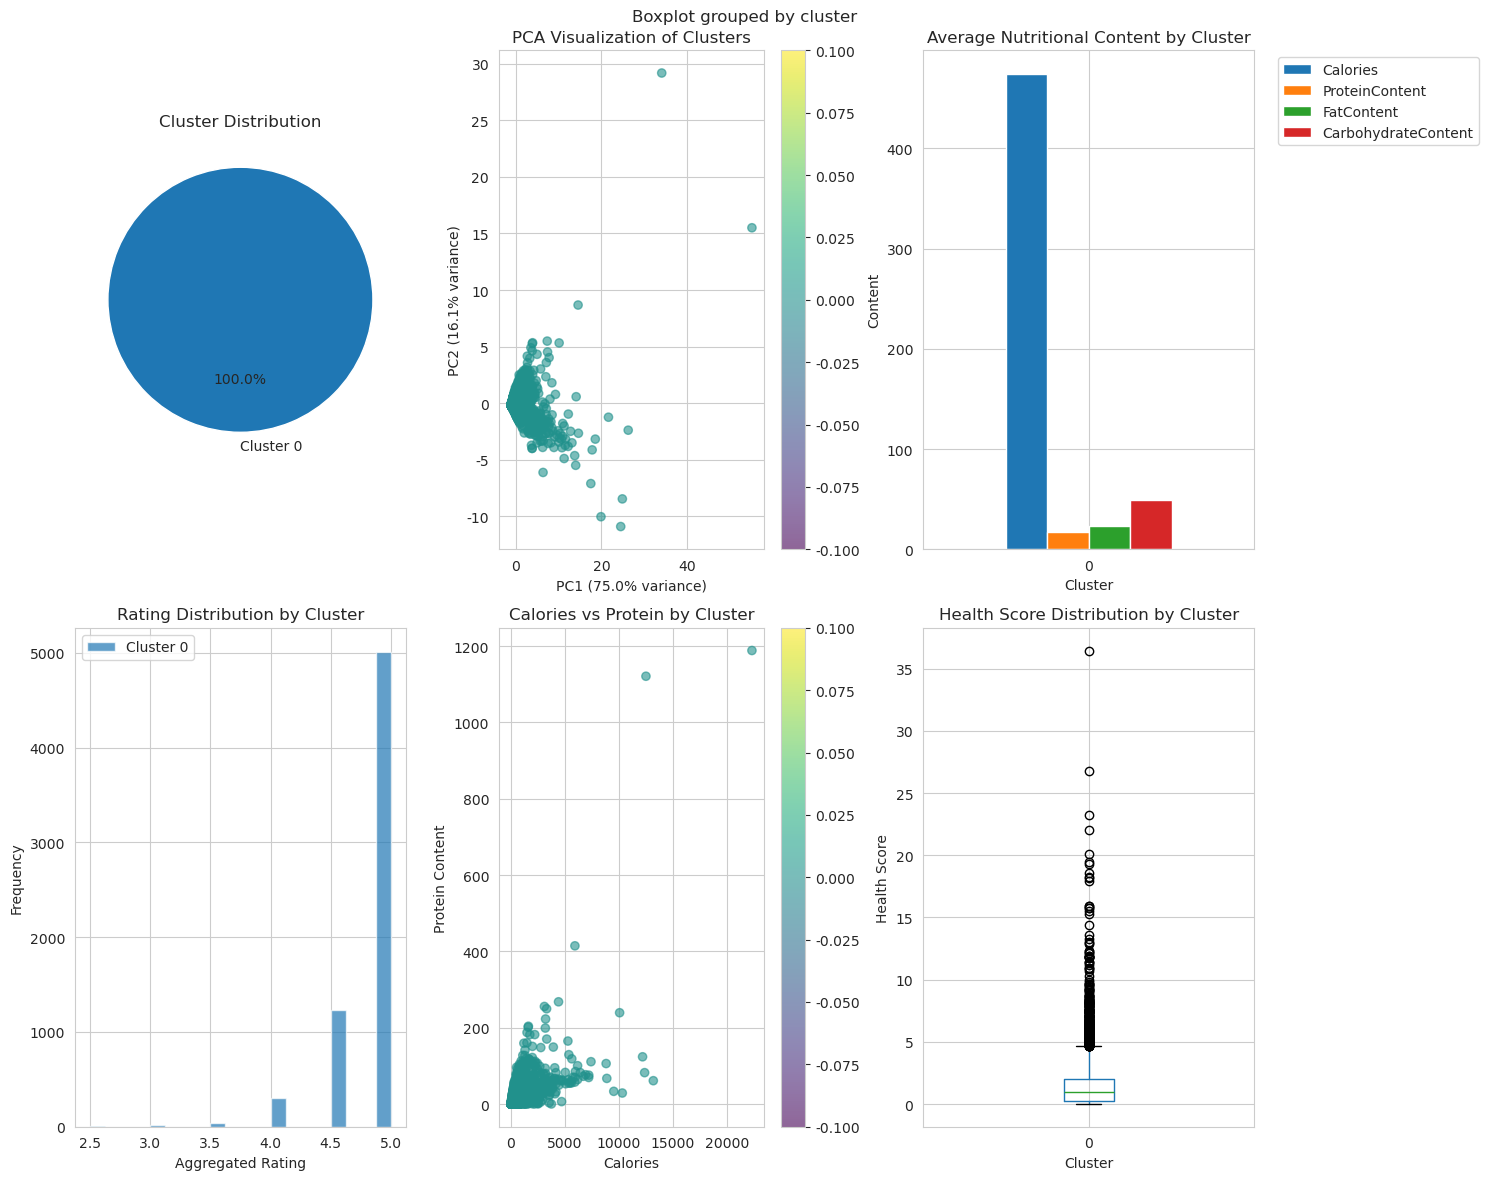


CLUSTERING INSIGHTS

Cluster 0 (66,151.0 recipes):
  - Average Calories: 466.3
  - Average Protein: 17.4g
  - Average Fat: 23.1g
  - Average Carbs: 47.9g
  - Average Rating: 4.84/5
  - Average Reviews: 16
  - Health Score: 1.54
  → High-calorie recipes
  → Healthier options
  → Highly rated recipes

Cluster 1 (1.0 recipes):
  - Average Calories: 90904.2
  - Average Protein: 2340.6g
  - Average Fat: 9491.0g
  - Average Carbs: 5415.2g
  - Average Rating: 4.50/5
  - Average Reviews: 30
  - Health Score: 0.89
  → High-calorie recipes
Saving results...
Results saved to:
- clustered_recipes.parquet
- cluster_summary.csv
- clustering_analysis.png

ANALYSIS COMPLETED SUCCESSFULLY!


In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Food.com Dataset Clustering Analysis
Recipe clustering based on nutritional components and user ratings
"""

import os
import warnings
warnings.filterwarnings('ignore')

# Spark configuration
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Python data processing and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler as SklearnScaler
from sklearn.cluster import KMeans as SklearnKMeans
from sklearn.metrics import silhouette_score
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set font and display settings
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
sns.set_style("whitegrid")

class FoodClusteringAnalysis:
    def __init__(self):
        """Initialize Spark configuration, optimized for 8-core 8GB setup"""
        self.spark = SparkSession.builder \
            .appName("Food.com Clustering Analysis") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .config("spark.executor.memory", "4g") \
            .config("spark.driver.memory", "2g") \
            .config("spark.executor.cores", "2") \
            .config("spark.executor.instances", "2") \
            .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
            .getOrCreate()
        
        self.spark.sparkContext.setLogLevel("WARN")
        
    def load_data(self, recipes_path="recipes.parquet", reviews_path="reviews.parquet"):
        """Load datasets"""
        print("Loading datasets...")
        
        # Load recipe data
        self.recipes_df = self.spark.read.parquet(recipes_path)
        print(f"Recipes loaded: {self.recipes_df.count():,} rows")
        
        # Load review data
        self.reviews_df = self.spark.read.parquet(reviews_path)
        print(f"Reviews loaded: {self.reviews_df.count():,} rows")
        
        return self
    
    def preprocess_data(self):
        """Data preprocessing and feature engineering"""
        print("Preprocessing data...")
        
        # Clean and transform nutritional data
        nutrition_cols = [
            'Calories', 'FatContent', 'SaturatedFatContent', 
            'CholesterolContent', 'SodiumContent', 'CarbohydrateContent',
            'FiberContent', 'SugarContent', 'ProteinContent'
        ]
        
        # Filter valid data
        self.recipes_clean = self.recipes_df.filter(
            col('AggregatedRating').isNotNull() & 
            col('ReviewCount').isNotNull() &
            (col('ReviewCount') >= 5)  # At least 5 reviews
        )
        
        # Fill missing nutritional values with median
        for col_name in nutrition_cols:
            median_val = self.recipes_clean.approxQuantile(col_name, [0.5], 0.01)[0]
            if median_val is not None:
                self.recipes_clean = self.recipes_clean.fillna({col_name: median_val})
        
        # Calculate additional features
        self.recipes_features = self.recipes_clean.withColumn(
            'CaloriesPerServing', 
            when(col('RecipeServings') > 0, col('Calories') / col('RecipeServings')).otherwise(col('Calories'))
        ).withColumn(
            'TotalFat', col('FatContent') + col('SaturatedFatContent')
        ).withColumn(
            'HealthScore', 
            (col('FiberContent') + col('ProteinContent')) / (col('SugarContent') + col('SaturatedFatContent') + 1)
        )
        
        print(f"Cleaned data: {self.recipes_features.count():,} recipes")
        return self
    
    def spark_clustering(self, k_range=(2, 10)):
        """Perform K-means clustering using Spark MLlib"""
        print("Performing Spark K-means clustering...")
        
        # Select clustering features
        feature_cols = [
            'Calories', 'FatContent', 'ProteinContent', 'CarbohydrateContent',
            'SodiumContent', 'SugarContent', 'FiberContent', 'AggregatedRating',
            'ReviewCount', 'CaloriesPerServing', 'HealthScore'
        ]
        
        # Vectorize features
        assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
        feature_data = assembler.transform(self.recipes_features)
        
        # Standardize features
        scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")
        scaler_model = scaler.fit(feature_data)
        scaled_data = scaler_model.transform(feature_data)
        
        # Find optimal K value
        silhouette_scores = []
        k_values = list(range(k_range[0], k_range[1] + 1))
        
        for k in k_values:
            kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=k, seed=42)
            model = kmeans.fit(scaled_data)
            predictions = model.transform(scaled_data)
            
            evaluator = ClusteringEvaluator(featuresCol="scaledFeatures", predictionCol="cluster")
            score = evaluator.evaluate(predictions)
            silhouette_scores.append(score)
            print(f"K={k}, Silhouette Score={score:.4f}")
        
        # Select optimal K value
        optimal_k = k_values[np.argmax(silhouette_scores)]
        print(f"Optimal K: {optimal_k}")
        
        # Perform final clustering with optimal K
        kmeans = KMeans(featuresCol="scaledFeatures", predictionCol="cluster", k=optimal_k, seed=42)
        self.kmeans_model = kmeans.fit(scaled_data)
        self.clustered_data = self.kmeans_model.transform(scaled_data)
        
        # Cache results
        self.clustered_data.cache()
        
        return self
    
    def analyze_clusters(self):
        """Analyze clustering results"""
        print("Analyzing cluster characteristics...")
        
        # Clustering statistics
        cluster_stats = self.clustered_data.groupBy("cluster").agg(
            count("*").alias("recipe_count"),
            avg("Calories").alias("avg_calories"),
            avg("ProteinContent").alias("avg_protein"),
            avg("FatContent").alias("avg_fat"),
            avg("CarbohydrateContent").alias("avg_carbs"),
            avg("AggregatedRating").alias("avg_rating"),
            avg("ReviewCount").alias("avg_reviews"),
            avg("HealthScore").alias("avg_health_score")
        ).orderBy("cluster")
        
        self.cluster_summary = cluster_stats.toPandas()
        print("\nCluster Summary:")
        print(self.cluster_summary.round(2))
        
        return self
    
    def visualize_results(self):
        """Visualize clustering results"""
        print("Creating visualizations...")
        
        # Convert to Pandas for visualization
        viz_data = self.clustered_data.select(
            "cluster", "Calories", "ProteinContent", "FatContent", 
            "CarbohydrateContent", "AggregatedRating", "ReviewCount", "HealthScore"
        ).sample(fraction=0.1, seed=42).toPandas()  # Sample 10% of data for visualization
        
        # 1. Cluster distribution pie chart
        plt.figure(figsize=(15, 12))
        
        plt.subplot(2, 3, 1)
        cluster_counts = viz_data['cluster'].value_counts().sort_index()
        plt.pie(cluster_counts.values, labels=[f'Cluster {i}' for i in cluster_counts.index], 
                autopct='%1.1f%%', startangle=90)
        plt.title('Cluster Distribution')
        
        # 2. PCA dimensionality reduction visualization
        plt.subplot(2, 3, 2)
        features = viz_data[['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent']].values
        scaler = SklearnScaler()
        features_scaled = scaler.fit_transform(features)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(features_scaled)
        
        scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], c=viz_data['cluster'], 
                           cmap='viridis', alpha=0.6)
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
        plt.title('PCA Visualization of Clusters')
        plt.colorbar(scatter)
        
        # 3. Nutritional content comparison
        plt.subplot(2, 3, 3)
        nutrition_means = viz_data.groupby('cluster')[['Calories', 'ProteinContent', 'FatContent', 'CarbohydrateContent']].mean()
        nutrition_means.plot(kind='bar', ax=plt.gca())
        plt.title('Average Nutritional Content by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Content')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=0)
        
        # 4. Rating distribution
        plt.subplot(2, 3, 4)
        for cluster in sorted(viz_data['cluster'].unique()):
            cluster_ratings = viz_data[viz_data['cluster'] == cluster]['AggregatedRating']
            plt.hist(cluster_ratings, alpha=0.7, label=f'Cluster {cluster}', bins=20)
        plt.xlabel('Aggregated Rating')
        plt.ylabel('Frequency')
        plt.title('Rating Distribution by Cluster')
        plt.legend()
        
        # 5. Calories vs Protein scatter plot
        plt.subplot(2, 3, 5)
        scatter = plt.scatter(viz_data['Calories'], viz_data['ProteinContent'], 
                           c=viz_data['cluster'], cmap='viridis', alpha=0.6)
        plt.xlabel('Calories')
        plt.ylabel('Protein Content')
        plt.title('Calories vs Protein by Cluster')
        plt.colorbar(scatter)
        
        # 6. Health score distribution
        plt.subplot(2, 3, 6)
        viz_data.boxplot(column='HealthScore', by='cluster', ax=plt.gca())
        plt.title('Health Score Distribution by Cluster')
        plt.xlabel('Cluster')
        plt.ylabel('Health Score')
        
        plt.tight_layout()
        plt.savefig('clustering_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return self
    
    def generate_insights(self):
        """Generate clustering insights"""
        print("\n" + "="*50)
        print("CLUSTERING INSIGHTS")
        print("="*50)
        
        for idx, row in self.cluster_summary.iterrows():
            cluster_id = int(row['cluster'])
            print(f"\nCluster {cluster_id} ({row['recipe_count']:,} recipes):")
            print(f"  - Average Calories: {row['avg_calories']:.1f}")
            print(f"  - Average Protein: {row['avg_protein']:.1f}g")
            print(f"  - Average Fat: {row['avg_fat']:.1f}g")
            print(f"  - Average Carbs: {row['avg_carbs']:.1f}g")
            print(f"  - Average Rating: {row['avg_rating']:.2f}/5")
            print(f"  - Average Reviews: {row['avg_reviews']:.0f}")
            print(f"  - Health Score: {row['avg_health_score']:.2f}")
            
            # Give cluster interpretations based on features
            if row['avg_calories'] > 400:
                print(f"  → High-calorie recipes")
            elif row['avg_calories'] < 200:
                print(f"  → Low-calorie recipes")
            
            if row['avg_health_score'] > 1:
                print(f"  → Healthier options")
            elif row['avg_health_score'] < 0.5:
                print(f"  → Less healthy options")
                
            if row['avg_rating'] > 4.5:
                print(f"  → Highly rated recipes")
    
    def save_results(self):
        """Save clustering results"""
        print("Saving results...")
        
        # Save clustering results to file
        output_data = self.clustered_data.select(
            "RecipeId", "Name", "cluster", "Calories", "ProteinContent", 
            "FatContent", "AggregatedRating", "ReviewCount"
        )
        
        # Write to parquet file
        output_data.coalesce(1).write.mode("overwrite").parquet("clustered_recipes.parquet")
        
        # Save clustering statistics
        self.cluster_summary.to_csv("cluster_summary.csv", index=False)
        
        print("Results saved to:")
        print("- clustered_recipes.parquet")
        print("- cluster_summary.csv")
        print("- clustering_analysis.png")
        
        return self
    
    def run_complete_analysis(self, recipes_path="recipes.parquet", reviews_path="reviews.parquet"):
        """Run complete clustering analysis pipeline"""
        try:
            self.load_data(recipes_path, reviews_path)
            self.preprocess_data()
            self.spark_clustering()
            self.analyze_clusters()
            self.visualize_results()
            self.generate_insights()
            self.save_results()
            
            print("\n" + "="*50)
            print("ANALYSIS COMPLETED SUCCESSFULLY!")
            print("="*50)
            
        except Exception as e:
            print(f"Error during analysis: {str(e)}")
            raise
        finally:
            self.spark.stop()

def main():
    """Main function"""
    print("Starting Food.com Clustering Analysis")
    print("System: 8-core 8GB Linux")
    print("="*50)
    
    # Create analysis instance and run
    analyzer = FoodClusteringAnalysis()
    analyzer.run_complete_analysis()

if __name__ == "__main__":
    main()

## 关联规则

Spark Session initialized for 8-core 8GB system
Loading Food.com datasets...
Recipes loaded: 522,517 rows
Reviews loaded: 1,401,982 rows
Preprocessing ingredients...
Processed recipes: 510,905
Sample processed ingredients:
- Low-Fat Berry Blue Frozen Dessert: ['blueberries', 'granulated sugar', 'vanilla yogurt', 'lemon juice']
- Biryani: ['saffron', 'milk', 'hot green chili peppers', 'onions', 'garlic', 'clove', 'peppercorns', 'cardamom seed', 'cumin seed', 'poppy seed', 'mace', 'cilantro', 'mint leaf', 'lemon juice', 'plain yogurt', 'boneless chicken', 'ghee', 'onion', 'tomatoes', 'basmati rice', 'longgrain rice', 'raisins', 'cashews', 'eggs']
- Best Lemonade: ['sugar', 'lemons rind of', 'lemon zest of', 'water', 'lemon juice']
- Carina's Tofu-Vegetable Kebabs: ['firm tofu', 'eggplant', 'zucchini', 'mushrooms', 'soy sauce', 'low sodium soy sauce', 'olive oil', 'maple syrup', 'honey', 'red wine vinegar', 'lemon juice', 'garlic cloves', 'mustard powder', 'black pepper']
- Cabbage Soup: 

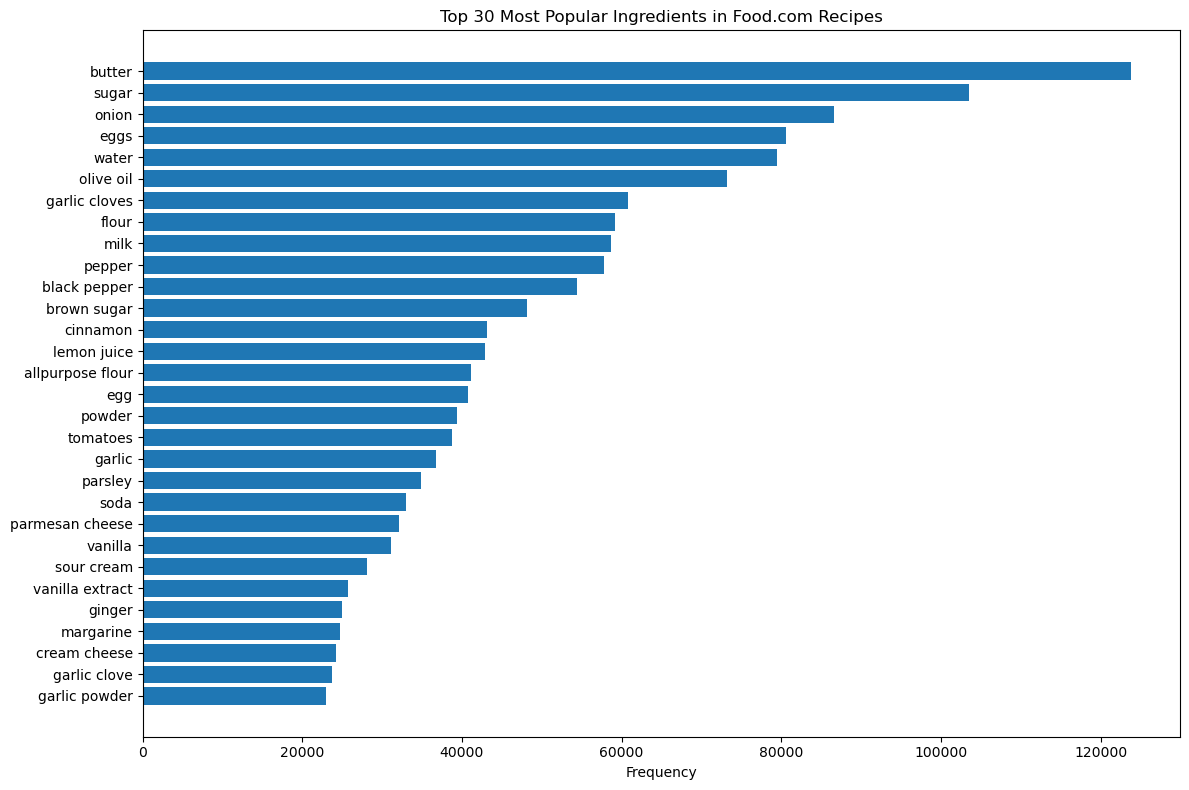


2. Analyzing association rules...
Analyzing top 30 association rules...
Retrieved 30 rules for analysis
Sample rule structure: ['__add__', '__call__', '__class__', '__class_getitem__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__fields__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getnewargs__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'asDict', 'count', 'index']
Sample rule: Row(antecedent=['nutmeg', 'soda'], consequent=['cinnamon'], confidence=0.8740705205085152, lift=10.351096362718533, support=0.007132441451933334)
Created DataFrame with 30 rules
DataFrame columns: ['Antecedent', 'Consequent', 'Confidence', 'Lift', 'Support']
Sample data:
             Antecedent Consequent  Confidenc

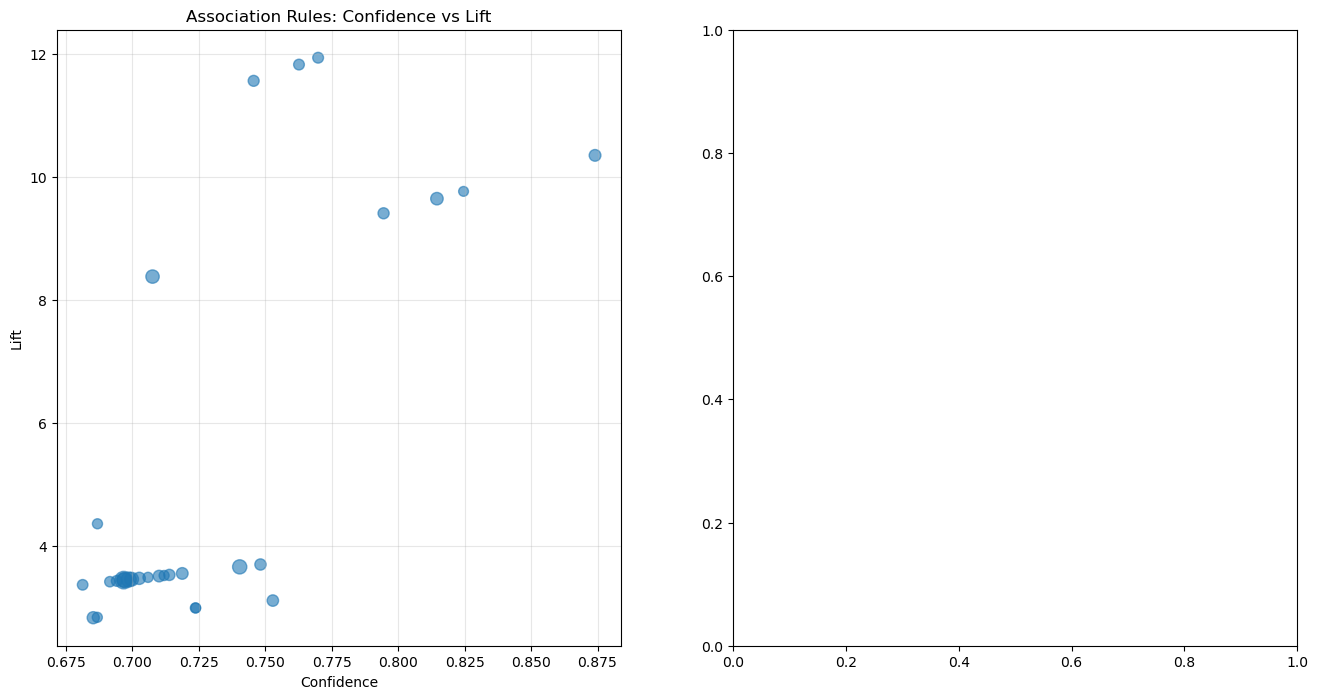

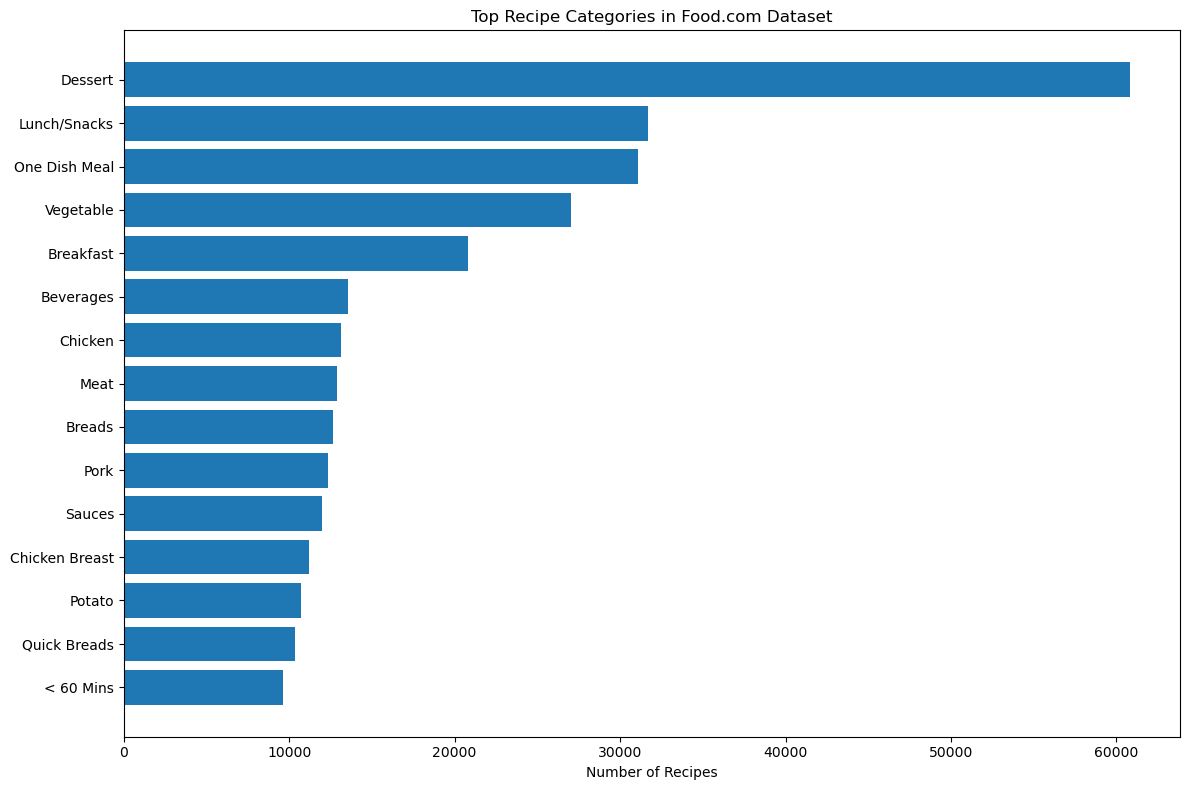


4. Finding specific ingredient combinations...
Found 0 rules involving 'chicken' (confidence >= 0.4):
No rules found for 'chicken' with confidence >= 0.4

5. Finding combinations with 'garlic'...
Found 0 rules involving 'garlic' (confidence >= 0.4):
No rules found for 'garlic' with confidence >= 0.4
Found 2 rules with any confidence level:
Error searching for ingredient combinations: min() takes 1 positional argument but 2 were given

FOOD.COM ASSOCIATION RULES MINING REPORT
Dataset Statistics:
- Total processed recipes: 510,905
- Frequent itemsets found: 1,241
- Association rules generated: 1,101

Top 10 Frequent Itemsets:
- butter (frequency: 123737)
- sugar (frequency: 103444)
- onion (frequency: 86606)
- eggs (frequency: 80527)
- water (frequency: 79427)
- olive oil (frequency: 73249)
- garlic cloves (frequency: 60811)
- flour (frequency: 59169)
- milk (frequency: 58639)
- pepper (frequency: 57786)

Top 10 Association Rules by Confidence:
- nutmeg + soda → cinnamon
  Confidence: 0

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Food.com Association Rules Mining
基于Food.com数据集的关联规则挖掘
Target: 8-core 8GB Linux system
"""

import os
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.fpm import FPGrowth
from pyspark.ml.feature import StringIndexer

# Set matplotlib to use English labels (avoid encoding issues)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('default')

class FoodAssociationMiner:
    def __init__(self):
        """Initialize Spark session optimized for 8-core 8GB system"""
        self.spark = SparkSession.builder \
            .appName("Food.com Association Rules Mining") \
            .config("spark.driver.memory", "4g") \
            .config("spark.executor.memory", "2g") \
            .config("spark.executor.cores", "2") \
            .config("spark.sql.adaptive.enabled", "true") \
            .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
            .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
            .getOrCreate()
        
        self.spark.sparkContext.setLogLevel("WARN")
        print("Spark Session initialized for 8-core 8GB system")
        
    def load_data(self, recipes_path="recipes.parquet", reviews_path="reviews.parquet"):
        """Load Food.com datasets"""
        print("Loading Food.com datasets...")
        
        # Load recipes data (using parquet for better performance)
        self.recipes_df = self.spark.read.parquet(recipes_path)
        print(f"Recipes loaded: {self.recipes_df.count():,} rows")
        
        # Load reviews data
        self.reviews_df = self.spark.read.parquet(reviews_path)
        print(f"Reviews loaded: {self.reviews_df.count():,} rows")
        
        # Cache for performance
        self.recipes_df.cache()
        self.reviews_df.cache()
        
        return self
    
    def preprocess_ingredients(self):
        """Preprocess recipe ingredients for association mining"""
        print("Preprocessing ingredients...")
        
        # Filter recipes with valid ingredients
        recipes_with_ingredients = self.recipes_df.filter(
            col("RecipeIngredientParts").isNotNull() & 
            (size(col("RecipeIngredientParts")) > 0)
        )
        
        # Define UDF for cleaning and deduplicating ingredients
        def clean_and_dedupe_ingredients(ingredients_array):
            """Clean ingredients and remove duplicates"""
            if not ingredients_array:
                return []
            
            cleaned_ingredients = []
            seen = set()
            
            for ingredient in ingredients_array:
                if not ingredient:
                    continue
                    
                # Convert to lowercase and remove extra spaces
                ingredient = ingredient.lower().strip()
                
                # Remove quantities and measurements
                ingredient = re.sub(r'\d+(\.\d+)?', '', ingredient)  # Remove numbers
                ingredient = re.sub(r'\b(cup|cups|tablespoon|tablespoons|teaspoon|teaspoons|pound|pounds|ounce|ounces|gram|grams|kg|lb|oz|tsp|tbsp|ml|l)\b', '', ingredient)
                
                # Remove common descriptive words
                ingredient = re.sub(r'\b(fresh|dried|chopped|minced|sliced|diced|ground|whole|large|small|medium|fine|coarse|extra|light|heavy)\b', '', ingredient)
                
                # Remove common cooking terms
                ingredient = re.sub(r'\b(for|cooking|baking|frying|optional|or|substitute|taste|flavor)\b', '', ingredient)
                
                # Clean up punctuation and extra spaces
                ingredient = re.sub(r'[^\w\s]', '', ingredient)  # Remove punctuation
                ingredient = ' '.join(ingredient.split())  # Remove extra spaces
                
                # Only keep meaningful ingredients (length > 2 and not common words)
                if len(ingredient) > 2 and ingredient not in {'and', 'the', 'for', 'with', 'oil', 'salt'}:
                    # Deduplicate - only add if not seen before
                    if ingredient not in seen:
                        cleaned_ingredients.append(ingredient)
                        seen.add(ingredient)
            
            return cleaned_ingredients
        
        # Register UDF
        clean_dedupe_udf = udf(clean_and_dedupe_ingredients, ArrayType(StringType()))
        
        # Process ingredients with cleaning and deduplication
        processed_recipes = recipes_with_ingredients \
            .withColumn("CleanedIngredients", clean_dedupe_udf(col("RecipeIngredientParts"))) \
            .filter(size(col("CleanedIngredients")) >= 2)  # At least 2 unique ingredients
        
        # Additional validation to ensure uniqueness
        processed_recipes = processed_recipes \
            .withColumn("UniqueIngredients", 
                       expr("array_distinct(CleanedIngredients)")) \
            .filter(size(col("UniqueIngredients")) >= 2) \
            .drop("CleanedIngredients") \
            .withColumnRenamed("UniqueIngredients", "FilteredIngredients")
        
        self.processed_recipes = processed_recipes.select(
            "RecipeId", "Name", "FilteredIngredients", "AggregatedRating", "ReviewCount"
        ).cache()
        
        print(f"Processed recipes: {self.processed_recipes.count():,}")
        
        # Debug: Show sample processed ingredients
        print("Sample processed ingredients:")
        sample_recipes = self.processed_recipes.limit(5).collect()
        for recipe in sample_recipes:
            print(f"- {recipe.Name}: {recipe.FilteredIngredients}")
        
        return self
    
    def mine_frequent_itemsets(self, min_support=0.01, min_confidence=0.3):
        """Mine frequent itemsets and association rules using FPGrowth"""
        print(f"Mining association rules (min_support={min_support}, min_confidence={min_confidence})...")
        
        # Prepare data for FPGrowth
        # Create ingredient transactions with additional validation
        transactions = self.processed_recipes.select(
            col("RecipeId").alias("id"),
            col("FilteredIngredients").alias("items")
        )
        
        # Additional safety check: ensure all transactions have unique items
        print("Validating transaction uniqueness...")
        
        # Add validation UDF
        def validate_unique_items(items):
            """Ensure items in transaction are unique"""
            if not items:
                return []
            # Convert to list and remove duplicates while preserving order
            seen = set()
            unique_items = []
            for item in items:
                if item and item not in seen:
                    unique_items.append(item)
                    seen.add(item)
            return unique_items
        
        validate_udf = udf(validate_unique_items, ArrayType(StringType()))
        
        # Apply validation
        validated_transactions = transactions \
            .withColumn("validated_items", validate_udf(col("items"))) \
            .filter(size(col("validated_items")) >= 2) \
            .select(col("id"), col("validated_items").alias("items"))
        
        print(f"Validated transactions: {validated_transactions.count():,}")
        
        # Show sample transactions for debugging
        print("Sample transactions:")
        sample_transactions = validated_transactions.limit(3).collect()
        for trans in sample_transactions:
            print(f"- Recipe {trans.id}: {trans.items}")
        
        effective_min_support = min_support if min_support >= 0.001 else 0.001
        
        fpGrowth = FPGrowth(
            itemsCol="items", 
            minSupport=effective_min_support,  # Use the calculated effective minimum support
            minConfidence=min_confidence
        )
        
        # Fit the model
        print("Training FPGrowth model...")
        try:
            model = fpGrowth.fit(validated_transactions)
            
            # Get frequent itemsets
            self.frequent_itemsets = model.freqItemsets
            print(f"Found {self.frequent_itemsets.count():,} frequent itemsets")
            
            # Get association rules
            self.association_rules = model.associationRules
            print(f"Found {self.association_rules.count():,} association rules")
            
            # Cache results
            self.frequent_itemsets.cache()
            self.association_rules.cache()
            
        except Exception as e:
            print(f"Error in FPGrowth: {str(e)}")
            print("Trying with higher minimum support...")
            
            # Retry with higher minimum support
            fpGrowth_retry = FPGrowth(
                itemsCol="items", 
                minSupport=0.005,  # Higher minimum support
                minConfidence=min_confidence
            )
            
            model = fpGrowth_retry.fit(validated_transactions)
            self.frequent_itemsets = model.freqItemsets
            self.association_rules = model.associationRules
            
            print(f"Found {self.frequent_itemsets.count():,} frequent itemsets")
            print(f"Found {self.association_rules.count():,} association rules")
            
            self.frequent_itemsets.cache()
            self.association_rules.cache()
        
        return self
    
    def analyze_ingredient_popularity(self):
        """Analyze ingredient popularity"""
        print("Analyzing ingredient popularity...")
        
        # Explode ingredients and count frequency
        ingredient_counts = self.processed_recipes \
            .select(explode(col("FilteredIngredients")).alias("ingredient")) \
            .groupBy("ingredient") \
            .count() \
            .orderBy(desc("count"))
        
        # Convert to pandas for visualization
        top_ingredients_pd = ingredient_counts.limit(30).toPandas()
        
        # Visualize top ingredients
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_ingredients_pd)), top_ingredients_pd['count'])
        plt.yticks(range(len(top_ingredients_pd)), top_ingredients_pd['ingredient'])
        plt.xlabel('Frequency')
        plt.title('Top 30 Most Popular Ingredients in Food.com Recipes')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('top_ingredients.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return top_ingredients_pd
    
    def analyze_association_rules(self, top_n=20):
        """Analyze and visualize association rules"""
        print(f"Analyzing top {top_n} association rules...")
        
        # Check if we have association rules
        if not hasattr(self, 'association_rules') or self.association_rules.count() == 0:
            print("No association rules found. Skipping analysis.")
            return pd.DataFrame()
        
        # Get top association rules by confidence
        try:
            top_rules = self.association_rules \
                .orderBy(desc("confidence")) \
                .limit(top_n) \
                .collect()
            
            print(f"Retrieved {len(top_rules)} rules for analysis")
            
            if len(top_rules) == 0:
                print("No rules retrieved. Returning empty DataFrame.")
                return pd.DataFrame()
            
            # Debug: Print first rule structure
            print(f"Sample rule structure: {dir(top_rules[0])}")
            print(f"Sample rule: {top_rules[0]}")
            
        except Exception as e:
            print(f"Error retrieving rules: {str(e)}")
            return pd.DataFrame()
        
        # Convert to readable format
        rules_data = []
        for rule in top_rules:
            try:
                antecedent = " + ".join(rule.antecedent) if rule.antecedent else "None"
                consequent = " + ".join(rule.consequent) if rule.consequent else "None"
                rules_data.append({
                    'Antecedent': antecedent,
                    'Consequent': consequent,
                    'Confidence': float(rule.confidence),
                    'Lift': float(rule.lift),
                    'Support': float(rule.support if hasattr(rule, 'support') else 0.0)
                })
            except Exception as e:
                print(f"Error processing rule: {str(e)}")
                continue
        
        if not rules_data:
            print("No valid rules data created. Returning empty DataFrame.")
            return pd.DataFrame()
        
        rules_df = pd.DataFrame(rules_data)
        print(f"Created DataFrame with {len(rules_df)} rules")
        print(f"DataFrame columns: {rules_df.columns.tolist()}")
        print(f"Sample data:\n{rules_df.head()}")
        
        # Check if we have enough data for visualization
        if len(rules_df) == 0:
            print("No rules to visualize.")
            return rules_df
        
        try:
            # Visualize association rules
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
            
            # Confidence vs Lift scatter plot
            ax1.scatter(rules_df['Confidence'], rules_df['Lift'], 
                       s=rules_df['Support']*10000, alpha=0.6)
            ax1.set_xlabel('Confidence')
            ax1.set_ylabel('Lift')
            ax1.set_title('Association Rules: Confidence vs Lift')
            ax1.grid(True, alpha=0.3)
            
            # Top rules by confidence
            top_10_rules = rules_df.head(min(10, len(rules_df)))
            y_pos = range(len(top_10_rules))
            ax2.barh(y_pos, top_10_rules['Confidence'])
            ax2.set_yticks(y_pos)
            
            # Create labels with proper error handling
            labels = []
            for _, row in top_10_rules.iterrows():
                try:
                    label = f"{row['Antecedent']} → {row['Consequent']}"
                    # Truncate long labels
                    if len(label) > 50:
                        label = label[:47] + "..."
                    labels.append(label)
                except:
                    labels.append("Rule")
            
            ax2.set_yticklabels(labels, fontsize=8)
            ax2.set_xlabel('Confidence')
            ax2.set_title('Top 10 Association Rules by Confidence')
            ax2.invert_yaxis()
            
            plt.tight_layout()
            plt.savefig('association_rules_analysis.png', dpi=300, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
        
        return rules_df
    
    def find_ingredient_combinations(self, target_ingredient, min_confidence=0.5):
        """Find ingredients that frequently appear with a target ingredient"""
        target_ingredient = target_ingredient.lower()
        
        # Check if we have association rules
        if not hasattr(self, 'association_rules') or self.association_rules.count() == 0:
            print(f"No association rules available to search for '{target_ingredient}'")
            return None
        
        try:
            # Filter rules containing the target ingredient
            target_rules = self.association_rules.filter(
                array_contains(col("antecedent"), target_ingredient) |
                array_contains(col("consequent"), target_ingredient)
            ).filter(col("confidence") >= min_confidence) \
             .orderBy(desc("confidence"))
            
            rule_count = target_rules.count()
            print(f"Found {rule_count} rules involving '{target_ingredient}' (confidence >= {min_confidence}):")
            
            if rule_count > 0:
                target_rules.show(min(20, rule_count), truncate=False)
            else:
                print(f"No rules found for '{target_ingredient}' with confidence >= {min_confidence}")
                # Try with lower confidence
                lower_conf_rules = self.association_rules.filter(
                    array_contains(col("antecedent"), target_ingredient) |
                    array_contains(col("consequent"), target_ingredient)
                ).orderBy(desc("confidence"))
                
                lower_count = lower_conf_rules.count()
                if lower_count > 0:
                    print(f"Found {lower_count} rules with any confidence level:")
                    lower_conf_rules.show(min(10, lower_count), truncate=False)
            
            return target_rules
            
        except Exception as e:
            print(f"Error searching for ingredient combinations: {str(e)}")
            return None
    
    def analyze_cuisine_patterns(self):
        """Analyze patterns by recipe categories"""
        print("Analyzing patterns by recipe categories...")
        
        # Join with original recipe data to get categories
        recipes_with_category = self.processed_recipes.join(
            self.recipes_df.select("RecipeId", "RecipeCategory"),
            "RecipeId"
        ).filter(col("RecipeCategory").isNotNull())
        
        # Count recipes by category
        category_counts = recipes_with_category \
            .groupBy("RecipeCategory") \
            .count() \
            .orderBy(desc("count"))
        
        # Get top categories
        top_categories = category_counts.limit(15).toPandas()
        
        # Visualize
        plt.figure(figsize=(12, 8))
        plt.barh(range(len(top_categories)), top_categories['count'])
        plt.yticks(range(len(top_categories)), top_categories['RecipeCategory'])
        plt.xlabel('Number of Recipes')
        plt.title('Top Recipe Categories in Food.com Dataset')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.savefig('recipe_categories.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return top_categories
    
    def generate_report(self):
        """Generate comprehensive analysis report"""
        print("\n" + "="*60)
        print("FOOD.COM ASSOCIATION RULES MINING REPORT")
        print("="*60)
        
        # Basic statistics
        total_recipes = self.processed_recipes.count()
        
        print(f"Dataset Statistics:")
        print(f"- Total processed recipes: {total_recipes:,}")
        
        # Check if we have results
        if hasattr(self, 'frequent_itemsets') and hasattr(self, 'association_rules'):
            try:
                total_frequent_itemsets = self.frequent_itemsets.count()
                total_rules = self.association_rules.count()
                
                print(f"- Frequent itemsets found: {total_frequent_itemsets:,}")
                print(f"- Association rules generated: {total_rules:,}")
                
                if total_frequent_itemsets > 0:
                    # Top frequent itemsets
                    print(f"\nTop 10 Frequent Itemsets:")
                    top_itemsets = self.frequent_itemsets.orderBy(desc("freq")).limit(10)
                    for row in top_itemsets.collect():
                        items = " + ".join(row.items) if row.items else "Empty"
                        print(f"- {items} (frequency: {row.freq})")
                else:
                    print("- No frequent itemsets found")
                
                if total_rules > 0:
                    # Top association rules
                    print(f"\nTop 10 Association Rules by Confidence:")
                    top_rules = self.association_rules.orderBy(desc("confidence")).limit(10)
                    for row in top_rules.collect():
                        antecedent = " + ".join(row.antecedent) if row.antecedent else "Empty"
                        consequent = " + ".join(row.consequent) if row.consequent else "Empty"
                        print(f"- {antecedent} → {consequent}")
                        print(f"  Confidence: {row.confidence:.3f}, Lift: {row.lift:.3f}")
                        if hasattr(row, 'support'):
                            print(f"  Support: {row.support:.4f}")
                else:
                    print("- No association rules found")
                    
            except Exception as e:
                print(f"Error generating detailed report: {str(e)}")
                print("- Mining results may not be available")
        else:
            print("- Mining not completed or failed")
        
        print("\n" + "="*60)
    
    def close(self):
        """Close Spark session"""
        self.spark.stop()
        print("Spark session closed")

def main():
    """Main execution function"""
    # Initialize miner
    miner = FoodAssociationMiner()
    
    try:
        # Load and process data
        miner.load_data() \
             .preprocess_ingredients() \
             .mine_frequent_itemsets(min_support=0.005, min_confidence=0.3)
        
        # Perform analysis
        print("\n1. Analyzing ingredient popularity...")
        top_ingredients = miner.analyze_ingredient_popularity()
        
        print("\n2. Analyzing association rules...")
        rules_df = miner.analyze_association_rules(top_n=30)
        
        print("\n3. Analyzing recipe categories...")
        categories = miner.analyze_cuisine_patterns()
        
        print("\n4. Finding specific ingredient combinations...")
        # Example: Find what goes well with "chicken"
        miner.find_ingredient_combinations("chicken", min_confidence=0.4)
        
        print("\n5. Finding combinations with 'garlic'...")
        miner.find_ingredient_combinations("garlic", min_confidence=0.4)
        
        # Generate final report
        miner.generate_report()
        
        print("\n✅ Association rules mining completed successfully!")
        print("Generated files:")
        print("- top_ingredients.png")
        print("- association_rules_analysis.png") 
        print("- recipe_categories.png")
        
    except Exception as e:
        print(f"❌ Error during execution: {str(e)}")
        import traceback
        traceback.print_exc()
    
    finally:
        # Clean up
        miner.close()

if __name__ == "__main__":
    main()

In [4]:
pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 6.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
